## 加载库

In [11]:
# 加载库
library(DMRcaller)
library(betareg)
library(tibble)
library(data.table)

# 设置字符集
Sys.setlocale("LC_ALL", "C.utf8")

getwd()


[1] "LC_CTYPE=C.utf8;LC_NUMERIC=C;LC_TIME=C.utf8;LC_COLLATE=C.utf8;LC_MONETARY=C.utf8;LC_MESSAGES=en_US.UTF-8;LC_PAPER=en_US.UTF-8;LC_NAME=C;LC_ADDRESS=C;LC_TELEPHONE=C;LC_MEASUREMENT=en_US.UTF-8;LC_IDENTIFICATION=C"

[1] "/methylation/F24A080000424_MUSekgzH_20240805100100"

## 设置参数

In [12]:
# 设置工作目录
setwd("/methylation/F24A080000424_MUSekgzH_20240805100100")

# # Sample names and conditions
# sample_names <- c("13A", "32A", "50A", "26A", "28A", "38A", "74A")
# condition <- c("Treatment", "Treatment", "Treatment", "Control", "Control", "Control", "Control")

# # 输出路径设置
# output_dir <- "output/治疗vs对照/" # 中间文件输出路径
# report_dir <- "report/治疗vs对照/" # 报告文件输出路径

# Sample names and conditions
sample_names <- c("13A", "32A", "50A", "25A", "75A", "88A", "97A")
condition <- c("Treatment", "Treatment", "Treatment", "Wild", "Wild", "Wild", "Wild")
# 输出路径设置
output_dir <- "output/治疗vs野生/" # 中间文件输出路径
report_dir <- "report/治疗vs野生/" # 报告文件输出路径

# 设置绘图的区域和染色体名称
start <- 3765000
end <- 3770000
seqname <- c("NC_000085.7")

# 设置基因组的cytoband文件路径（绘制环形图使用）
# 下载地址：https://hgdownload.cse.ucsc.edu/goldenPath/mm39/database/cytoBandIdeo.txt
cytoband_path <- "/methylation/cytoband/mm39/cytoBandIdeo.txt"

## 补充设置

In [13]:
# accession和chromosome的映射关系
accession2chromosome <- c(
  "NC_000067.7" = "chr1", "NC_000068.8" = "chr2", "NC_000069.7" = "chr3",
  "NC_000070.7" = "chr4", "NC_000071.7" = "chr5", "NC_000072.7" = "chr6",
  "NC_000073.7" = "chr7", "NC_000074.7" = "chr8", "NC_000075.7" = "chr9",
  "NC_000076.7" = "chr10", "NC_000077.7" = "chr11", "NC_000078.7" = "chr12",
  "NC_000079.7" = "chr13", "NC_000080.7" = "chr14", "NC_000081.7" = "chr15",
  "NC_000082.7" = "chr16", "NC_000083.7" = "chr17", "NC_000084.7" = "chr18",
  "NC_000085.7" = "chr19", "NC_000086.8" = "chrX", "NC_000087.8" = "chrY"
  # ,"NC_005089.1" = "chrM"
)
# 检查并创建中间文件输出路径
if (!dir.exists(output_dir)) {
  dir.create(output_dir, recursive = TRUE)
}

# 检查并创建报告文件输出路径
if (!dir.exists(report_dir)) {
  dir.create(report_dir, recursive = TRUE)
}


##  读甲基化数据

In [5]:
# Initialize an empty list to store the data
methylationDataList <- list()
# Loop through each sample name and read the corresponding file
for (i in seq_along(sample_names)) {
  file_path <- paste0(
    sample_names[i], "/output/bismark_methylation/",
    sample_names[i], "_1_bismark_bt2_pe.deduplicated.CX_report.txt.chr",
    seqname, ".CX_report.txt.gz"
  )
  methylationDataList[[i]] <- readBismark(file_path)
}

# Initialize methylationData with the first element of methylationDataList
methylationData <- methylationDataList[[1]]

# Loop through the rest of the list and merge each element into methylationData
for (i in 2:length(methylationDataList)) {
  methylationData <- joinReplicates(methylationData, methylationDataList[[i]])
}


Reading file: 13A/output/bismark_methylation/13A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Finished reading file: 13A/output/bismark_methylation/13A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Reading file: 32A/output/bismark_methylation/32A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Finished reading file: 32A/output/bismark_methylation/32A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Reading file: 50A/output/bismark_methylation/50A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Finished reading file: 50A/output/bismark_methylation/50A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Reading file: 25A/output/bismark_methylation/25A_1_bismark_bt2_pe.deduplicated.CX_report.txt.chrNC_000085.7.CX_report.txt.gz
Finished reading file: 25A/output/bismark_methylation/25A_1_bismark_bt2_pe.deduplicated.CX_report.

## 绘图

### 绘制甲基化位置分布图


In [14]:
library(ggplot2)
library(GenomicRanges)
library(dplyr)

# 设置绘图的区域和染色体名称
start <- 3765000
end <- 3770000
seqname <- c("NC_000085.7")
sample_names <- c("13A", "32A", "50A", "25A", "75A", "88A", "97A")
condition <- c("Treatment", "Treatment", "Treatment", "Wild", "Wild", "Wild", "Wild")

# 创建颜色映射
color_palette <- c("#E69F00", "#56B4E9", "#CC79A7", "#009E73", "#D55E00")
names(color_palette) <- unique(condition)


In [15]:
# 读取甲基化分布数据
df_list <- list()
region <- GRanges(seqname, IRanges(start, end))
methylationDataFiltered <- subsetByOverlaps(methylationData, region)
for (i in seq_along(condition)) {
  readsM <- mcols(methylationDataFiltered)[[paste0("readsM", i)]]
  readsN <- mcols(methylationDataFiltered)[[paste0("readsN", i)]]
  methylation_proportion <- readsM / readsN

  df_list[[i]] <- data.frame(
    position = start(methylationDataFiltered),
    methylation_proportion = methylation_proportion,
    condition = condition[i],
    sample = sample_names[i],
    label = paste(condition[i], ":", sample_names[i])
  )
}

# 合并所有样本的数据框
df <- do.call(rbind, df_list)
# 删除0或者NA
df <- subset(df, methylation_proportion != 0 & !is.na(methylation_proportion))

# 将 sample 列转换为因子，并指定级别顺序，用于分面时排序
df$sample <- factor(df$sample, levels = sample_names)

# 创建颜色映射
color_palette <- c("#E69F00", "#56B4E9", "#CC79A7", "#009E73", "#D55E00")
names(color_palette) <- unique(condition)

# # 按position分窗口求平均(当展示宽度特别大时使用)
# window_size <- 200 # 窗口宽度
# # 创建一个临时列，记录每行所在的窗口
# df <- df %>% mutate(
#   position_group = cut(
#     position,
#     breaks = seq(min(position), max(position), by = window_size),
#     include.lowest = TRUE
#   )
# )
# # 计算每个窗口的平均值，保留其他列
# avg_df <- df %>%
#   group_by(sample, position_group) %>%
#   summarise(
#     avg_methylation = mean(methylation_proportion, na.rm = TRUE),
#     across(everything(), first),
#     .groups = "drop"
#   ) %>%
#   select(-position_group) # 删除临时分组列

# 查看结果
head(df)


,position,methylation_proportion,condition,sample,label
,<int>,<dbl>,<chr>,<fct>,<chr>
20,3765033,0.3333333,Treatment,13A,Treatment : 13A
47,3765088,0.1000000,Treatment,13A,Treatment : 13A
88,3765167,0.1250000,Treatment,13A,Treatment : 13A
90,3765169,0.7500000,Treatment,13A,Treatment : 13A
91,3765170,0.8888889,Treatment,13A,Treatment : 13A
94,3765177,1.0000000,Treatment,13A,Treatment : 13A


In [16]:
# 读取DMR结果文件
DMRsReplicatesBinsCombined <- read.table(
  paste0(output_dir, "DMRsReplicatesBins.txt"),
  sep = "\t", header = FALSE, stringsAsFactors = FALSE
)
# 设置列名
colnames(DMRsReplicatesBinsCombined) <- c(
  "seqnames", "start", "end", "width", "strand", "sumReadsM1", "sumReadsN1",
  "proportion1", "sumReadsM2", "sumReadsN2", "proportion2", "cytosinesCount",
  "context", "direction", "pValue", "regionType"
)
# 筛选指定范围和 seqnames 的行
start_range_val <- start
end_range_val <- end
specified_seqnames <- accession2chromosome[seqname]
filtered_DMRs <- DMRsReplicatesBinsCombined %>%
  filter(start >= start_range_val & end <= end_range_val & seqnames == specified_seqnames)
head(filtered_DMRs)


,seqnames,start,end,width,strand,sumReadsM1,sumReadsN1,proportion1,sumReadsM2,sumReadsN2,proportion2,cytosinesCount,context,direction,pValue,regionType
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>
1,chr19,3768801,3769000,200,*,55,114,0.4827586,45,165,0.2754491,6,CG,-1,0.01142147,loss


In [10]:
library(rtracklayer)

# 读取 GTF注释 文件
gtf_file <- "/methylation/gencode/gencode.vM35.annotation.gtf"
gtf_data <- import(gtf_file, format = "gtf")


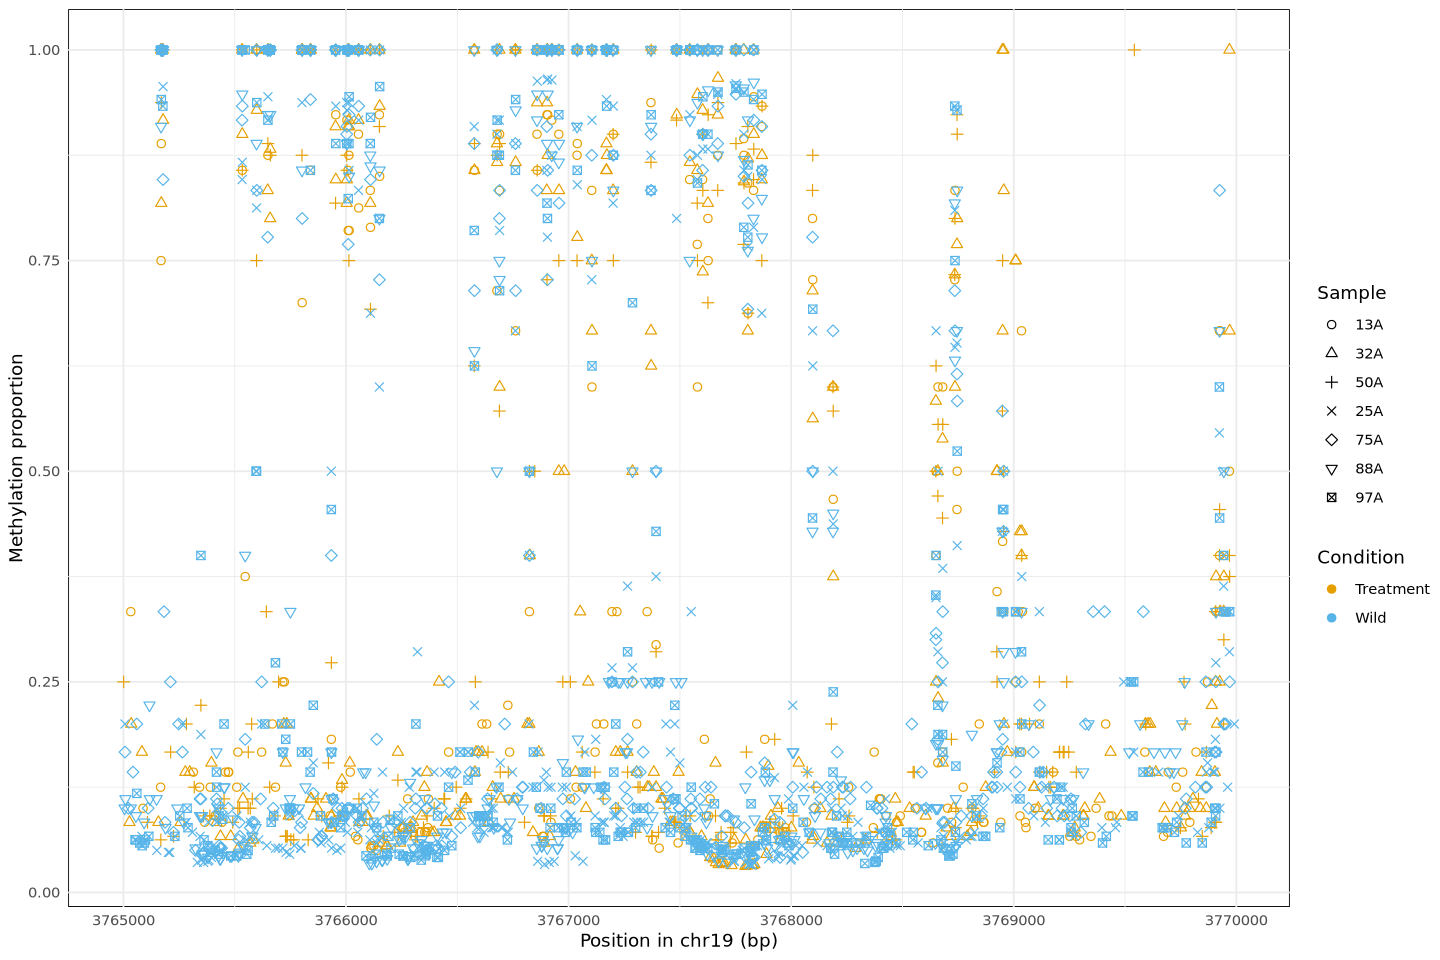

In [17]:
# 绘散点图（三选一执行）
options(repr.plot.width = 12, repr.plot.height = 8)
plot1 <- ggplot(df, aes(x = position, y = methylation_proportion)) +
  geom_point(aes(
    color = condition,
    shape = sample
  ), size = 2) +
  scale_color_manual(values = color_palette, labels = names(color_palette)) +
  scale_shape_manual(values = seq_along(sample_names), labels = sample_names) +
  labs(
    x = paste0("Position in ", accession2chromosome[seqname], " (bp)"),
    y = "Methylation proportion",
    color = "Condition",
    shape = "Sample",
  ) +
  # ylim(0, 1) +
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white")
  )
plot1


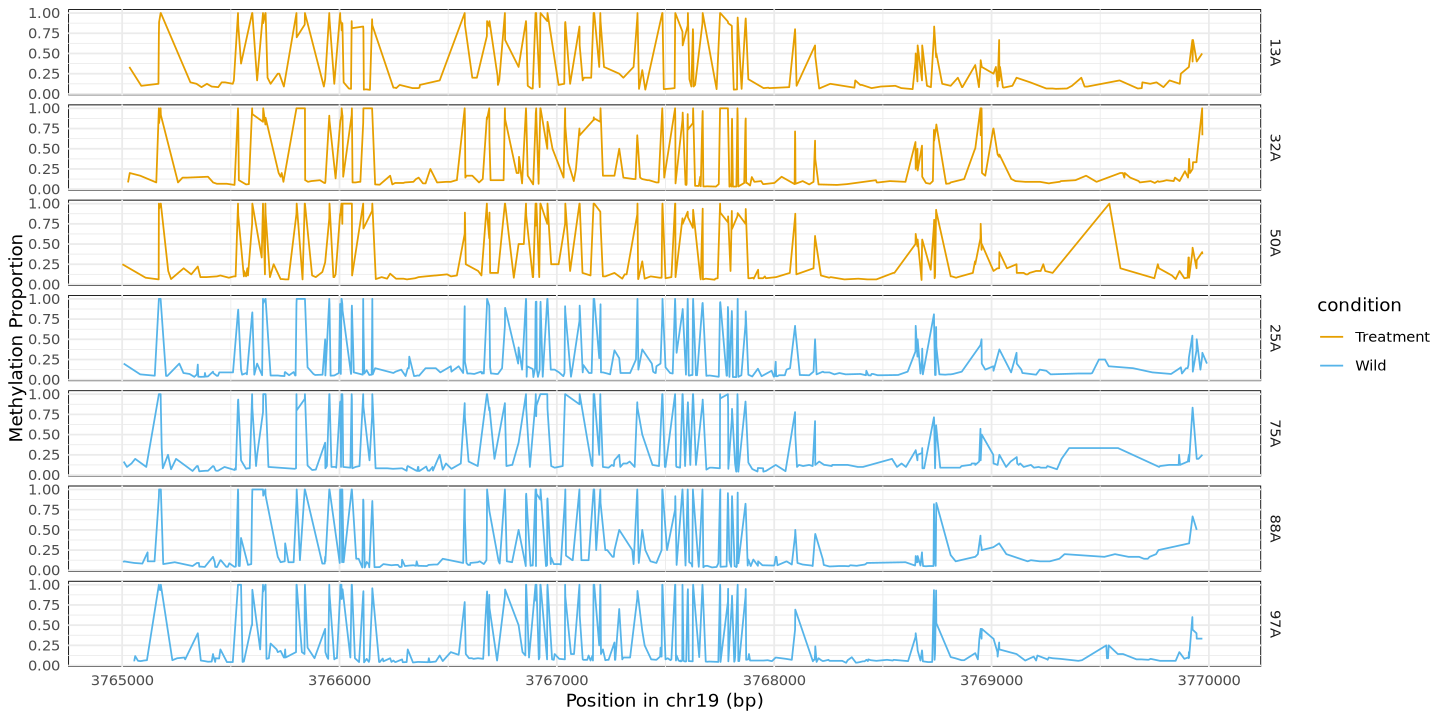

In [19]:
# 绘制折线图（按sample分面，三选一执行）
options(repr.plot.width = 12, repr.plot.height = 6)

plot1 <- ggplot(df, aes(x = position, y = methylation_proportion, color = condition)) +
  geom_line() +
  labs(
    x = paste0("Position in ", accession2chromosome[seqname], " (bp)"),
    y = "Methylation Proportion",
    fill = "Condition"
  ) +
  scale_color_manual(values = color_palette) + # 设置 condition 的颜色
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    strip.text.y.right = element_text(angle = 270), # 调整标题文本方向
    strip.placement = "outside" # 将标题放在外部
  ) +
  facet_grid(sample ~ .) # 按 sample 列分面，竖直排列并切换到右侧

print(plot1)


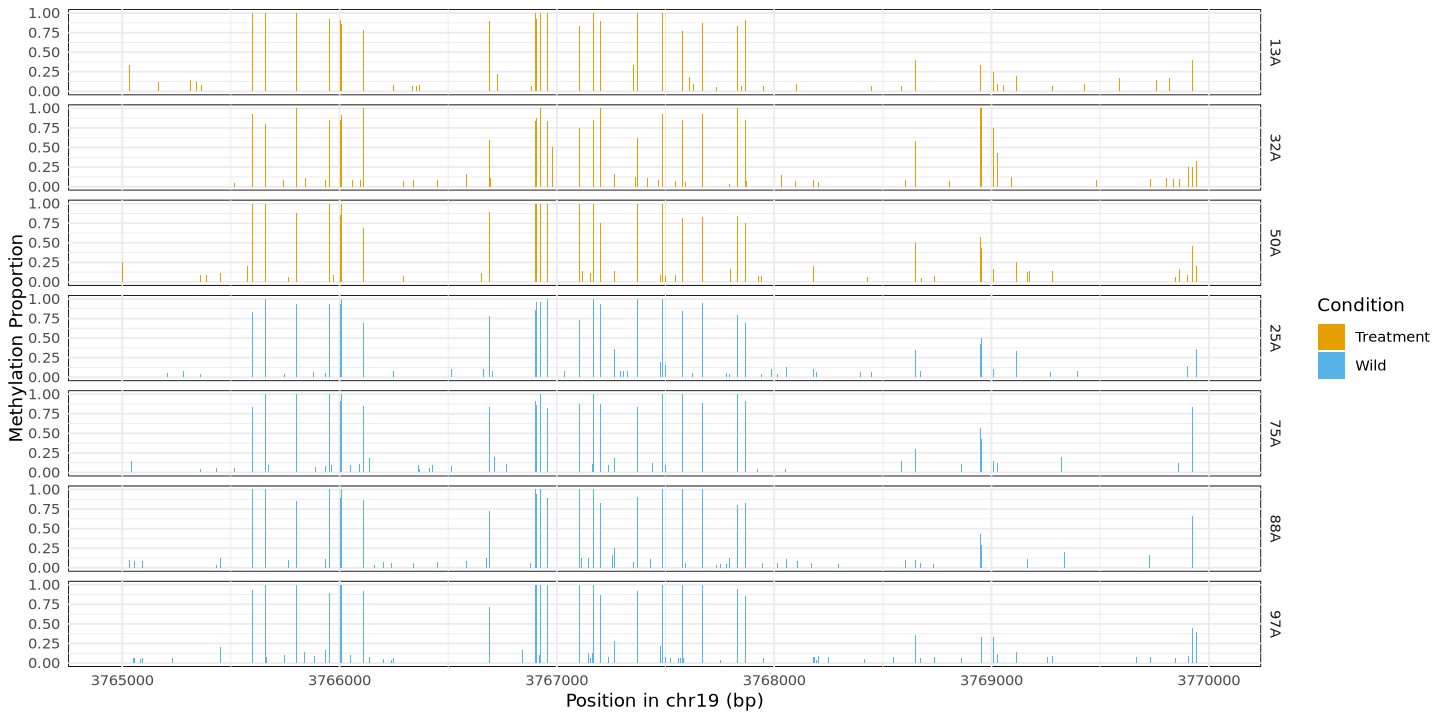

In [18]:
# 绘制柱状图（按sample分面，三选一执行）
options(repr.plot.width = 12, repr.plot.height = 6)

# 将 sample 列转换为因子，并指定级别顺序，用于分面时排序
df$sample <- factor(df$sample, levels = sample_names)

plot1 <- ggplot(df, aes(x = position, y = methylation_proportion, fill = condition)) +
  geom_bar(stat = "identity", position = "dodge") + # 使用柱状图
  labs(
    x = paste0("Position in ", accession2chromosome[seqname], " (bp)"),
    y = "Methylation Proportion",
    fill = "Condition"
  ) +
  scale_fill_manual(values = color_palette) + # 设置 condition 的颜色
  theme_minimal() +
  theme(
    panel.background = element_rect(fill = "white"),
    strip.text.y.right = element_text(angle = 270), # 调整文本方向
    strip.placement = "outside" # 将标签放在外部
  ) +
  facet_grid(sample ~ .) # 按 sample 列分面，竖直排列并切换到右侧

print(plot1)


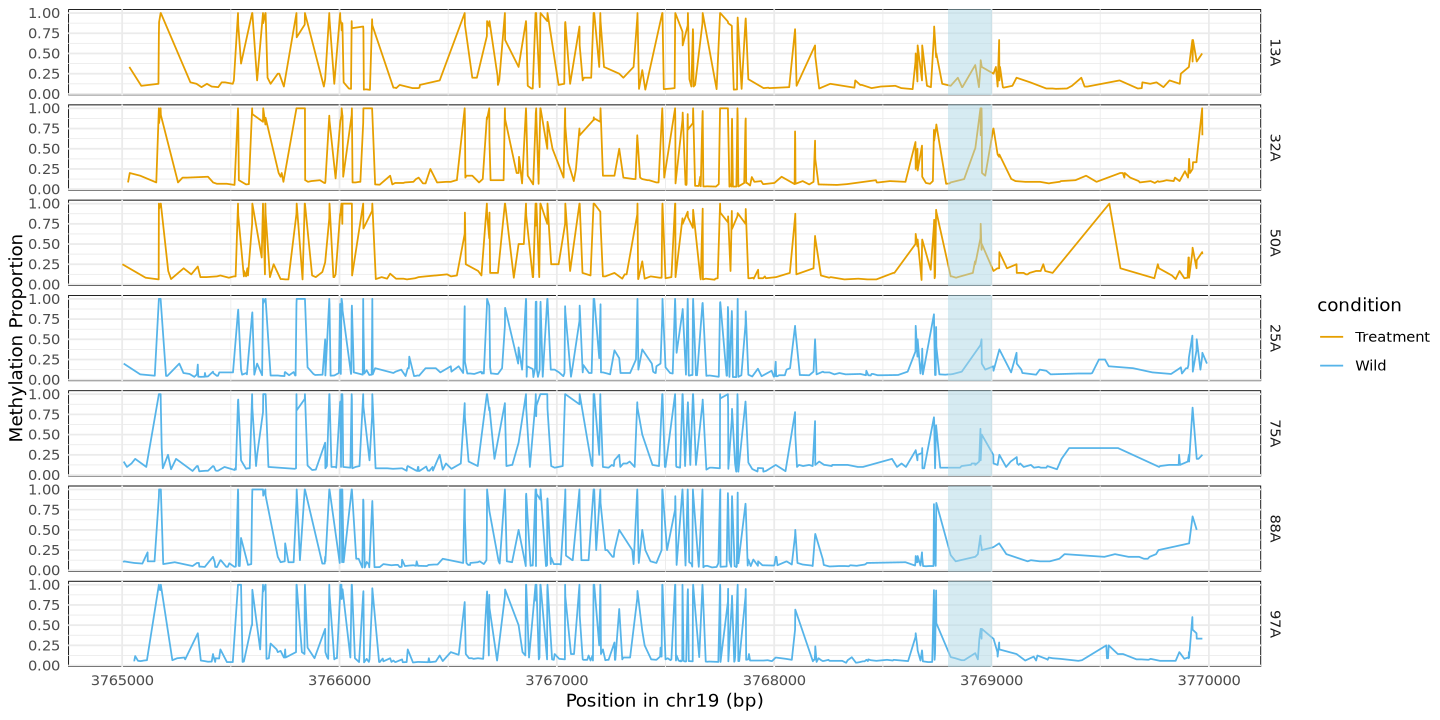

In [20]:
# 绘制DMR区域高亮
if (nrow(filtered_DMRs) > 0) { # 检查 filtered_DMRs 是否有数据
  # 创建一个数据框用于绘制矩形
  rect_data <- data.frame(
    xmin = filtered_DMRs$start,
    xmax = filtered_DMRs$end,
    ymin = -Inf,
    ymax = Inf
  )

  # 添加矩形层
  plot1 <- plot1 +
    geom_rect(
      data = rect_data, aes(xmin = xmin, xmax = xmax, ymin = ymin, ymax = ymax),
      fill = "lightblue", alpha = 0.5, inherit.aes = FALSE
    )
}

print(plot1)


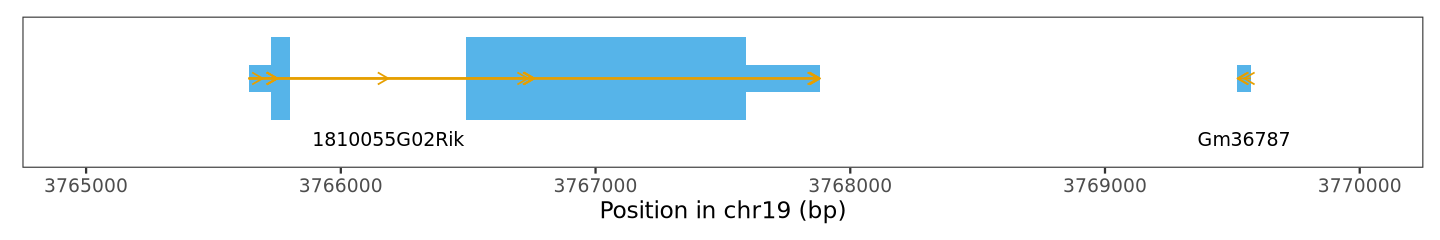

In [22]:
library(transPlotR)

# 绘制基因位置
# 教程地址：https://blog.csdn.net/qazplm12_3/article/details/125903915
options(repr.plot.width = 12, repr.plot.height = 2)
plot2 <- trancriptVis(
  gtfFile = as.data.frame(gtf_data), # 将 GTF 数据文件转换为数据框，并用于绘制转录本图
  Chr = accession2chromosome[seqname], # 将染色体的 accession 转换为实际染色体名称
  posStart = start, # 可视化区域的起始位置
  posEnd = end, # 可视化区域的结束位置
  textLabel = "gene_name", # 标签文字类型，可选 gene_name, transcript_name, transcript_id, gene_id
  collapse = TRUE, # 当多个转录本重叠时，是否将其折叠显示为一行
  textLabelSize = 4, # 标签文字大小
  relTextDist = -0.22, # 标签文字距离箭头的相对距离
  # textLabelColor = "red",            # 设置标签文字颜色（默认颜色为黑色）
  # exonColorBy = "transcript_name",   # 根据转录本名称为外显子着色（此行注释掉）
  # arrowType = "closed",              # 设置箭头的类型为闭合箭头（默认为开放箭头）
  arrowCol = "#e69f00", # 设置箭头的颜色为橙色
  exonFill = "#56b4e9", # 设置外显子区域的填充颜色为蓝色
  arrowBreak = 0.5 # 设置箭头的断开位置
) +
  labs(x = paste0("Position in ", accession2chromosome[seqname], " (bp)")) +
  ylim(0.7, 1.2) +
  scale_x_continuous(
    limits = c(start, end) # 设置 x 轴的显示范围为 start 和 end 之间
  ) # + theme_void()           # （可选）隐藏所有坐标轴和背景网格线

plot2


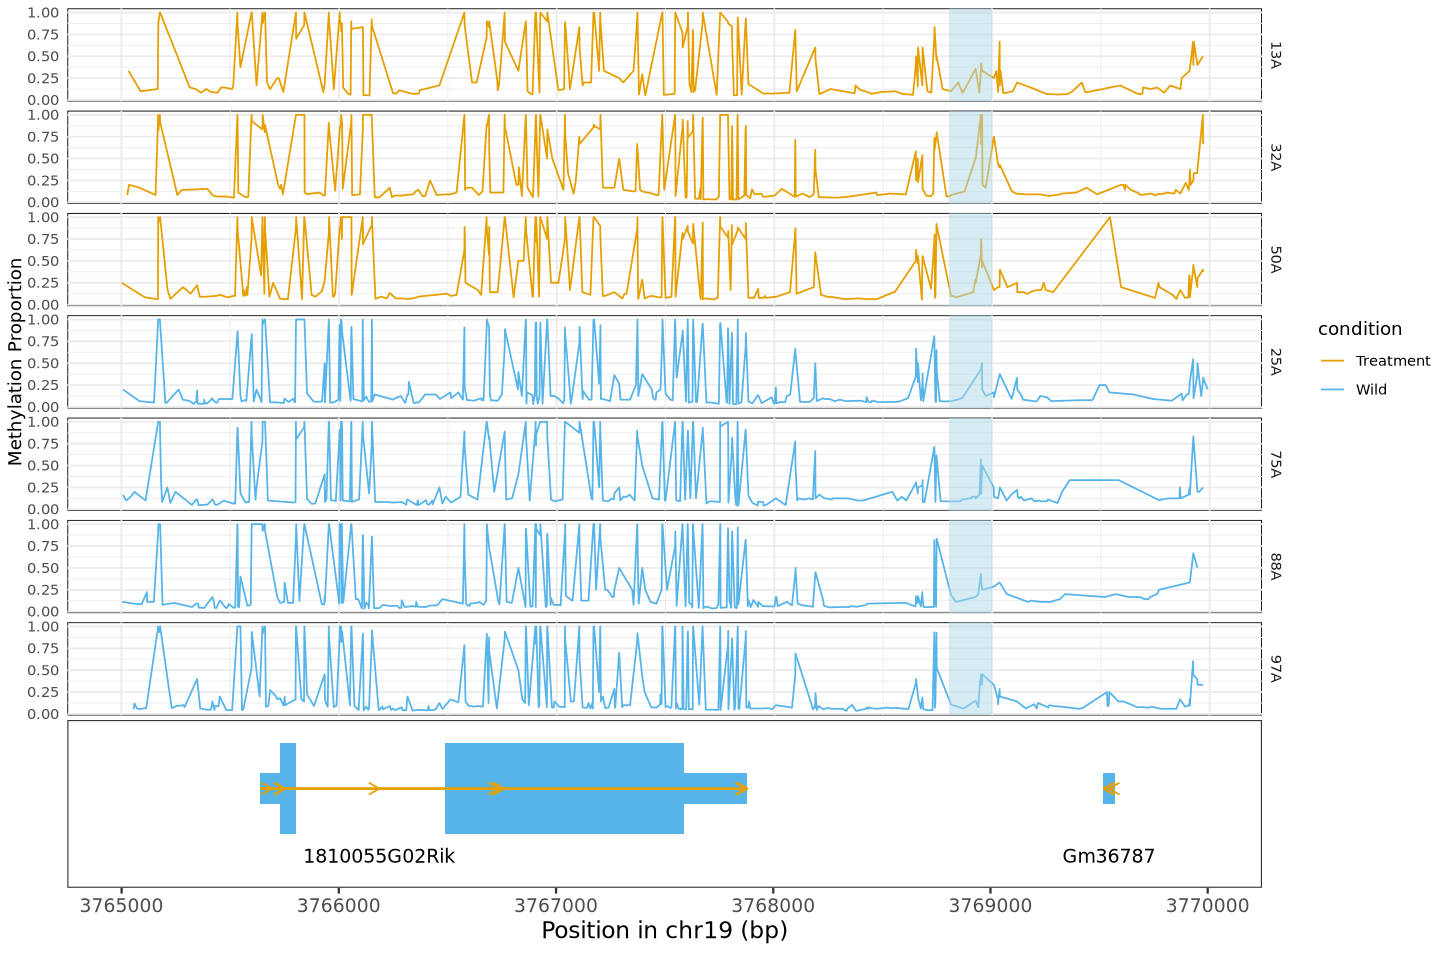

In [24]:
library(cowplot)

# 合并子图
options(repr.plot.width = 12, repr.plot.height = 8)
combined_plot <- plot_grid(
  plot1 +
    theme(
      axis.title.x = element_blank(), # 移除 x 轴标题
      axis.ticks.x = element_blank(), # 移除 x 轴刻度线
      axis.text.x = element_blank(), # 移除 x 轴刻度标签
      panel.border = element_blank(), # 移除面板边框
      plot.margin = margin(5, 5, 0, 5) # 设置图形周围的边距
    ),
  plot2 +
    theme(
      plot.margin = margin(0, 0, 10, 0) # 设置图形周围的边距
    ),
  ncol = 1, # 设置为 1 列，垂直排列
  align = "v", # 垂直对齐
  axis = "lrtb", # 设置轴参数以确保对齐
  rel_heights = c(6, 2) # 设置相对高度
)

# 显示合并后的图形
print(combined_plot)


### 绘制甲基化位置分布散点图

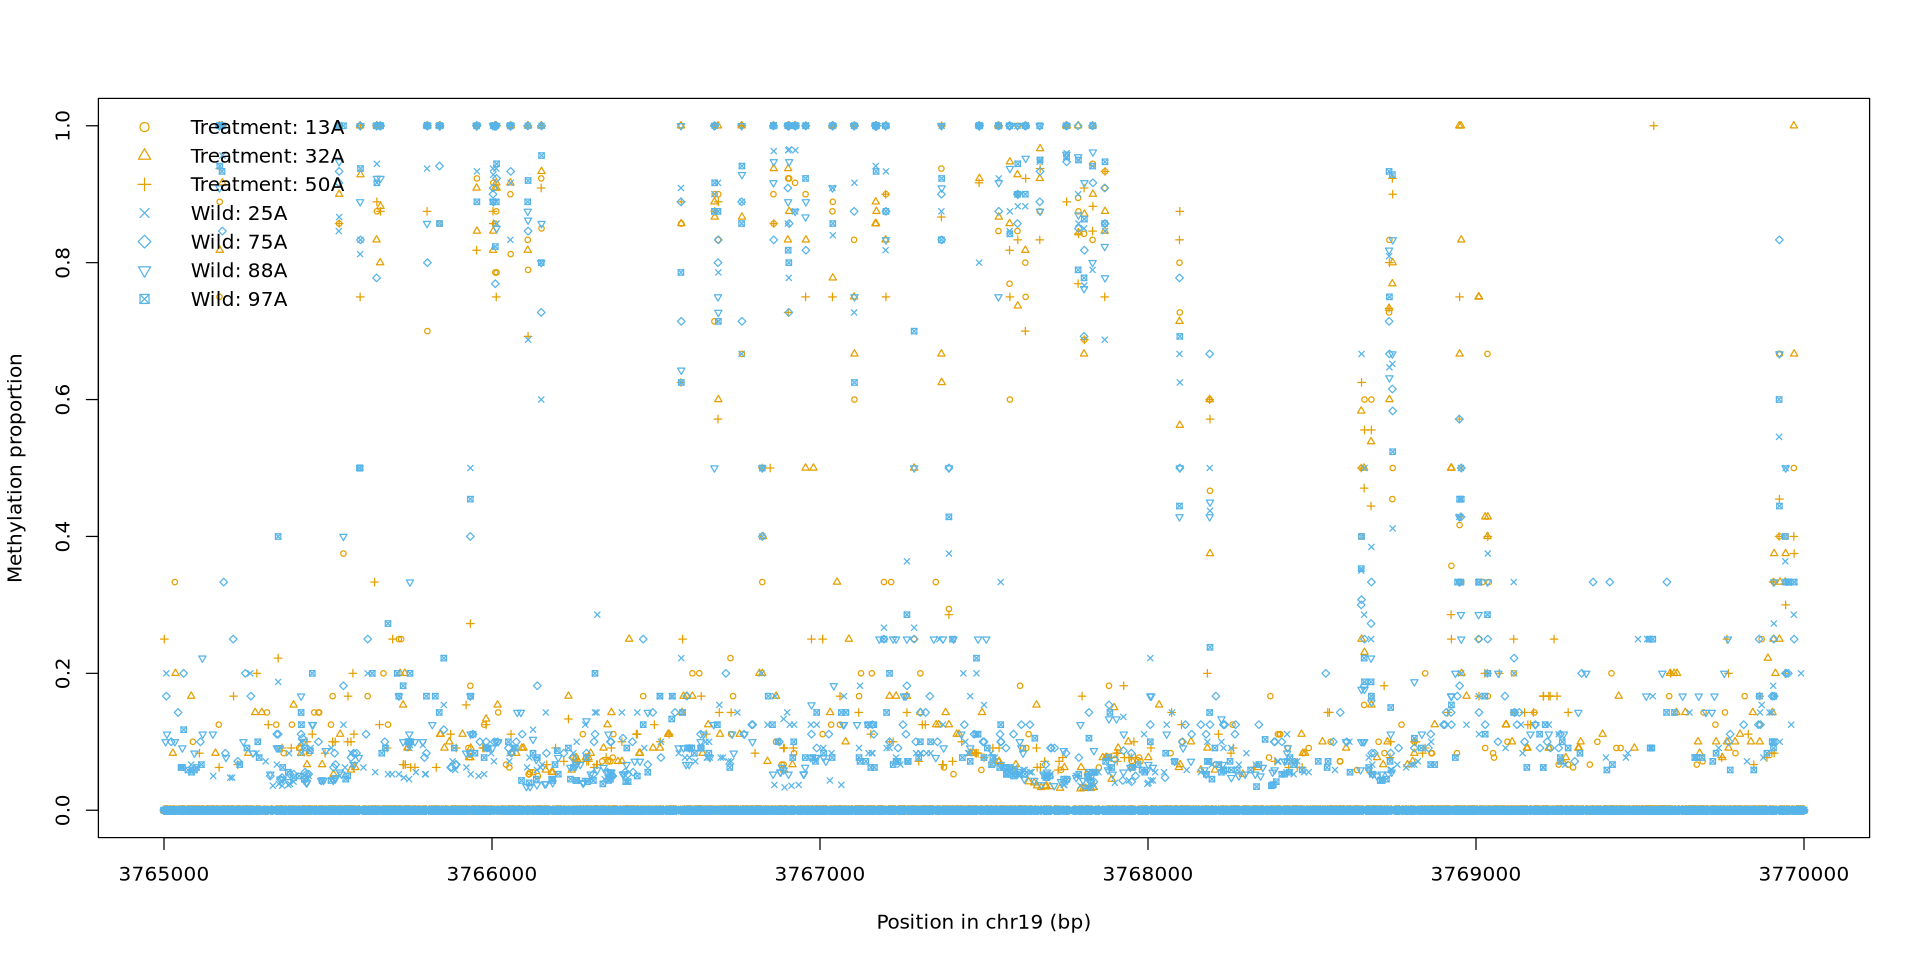

In [26]:
# 绘制每个样本的散点图
options(repr.plot.width = 16, repr.plot.height = 8)

region <- GRanges(seqname, IRanges(start, end))
methylationDataFiltered <- subsetByOverlaps(methylationData, region)


# 创建颜色映射，为每个组分配一个颜色
color_palette <- c("#E69F00", "#56B4E9", "#CC79A7", "#009E73", "#D55E00")
names(color_palette) <- unique(condition)

# 创建形状向量
shapes <- seq_along(condition) # 为每个样本分配不同的形状

par(bg = "white") # 设置背景为白色
# 绘制图形
plot <- plot(
  start(methylationDataFiltered),
  mcols(methylationDataFiltered)$readsM1 / mcols(methylationDataFiltered)$readsN1,
  ylim = c(0, 1),
  col = color_palette[condition[1]],
  pch = shapes[1],
  cex = 0.6,
  xlab = paste0("Position in ", accession2chromosome[seqname], " (bp)"),
  ylab = "Methylation proportion"
)
# 添加点
for (i in 2:length(condition)) {
  readsM <- mcols(methylationDataFiltered)[[paste0("readsM", i)]]
  readsN <- mcols(methylationDataFiltered)[[paste0("readsN", i)]]
  sample_data <- readsM / readsN
  sample_condition <- condition[i]

  # 根据条件设置颜色和形状
  points(
    start(methylationDataFiltered),
    sample_data,
    col = color_palette[sample_condition],
    pch = shapes[i],
    cex = 0.6,
  )
}
# 添加图例
legend(
  x = "topleft",
  legend = paste0(condition, ": ", sample_names),
  pch = shapes[seq_along(condition)],
  col = color_palette[condition],
  bty = "n", cex = 1.0
)


### 绘制DMR区域及相关基因在染色体上的分布环形图

In [27]:
# 读取DMR结果
colname_lists <- c("chr", "start", "end", "width", "strand", "sumReadsM1", "sumReadsN1", "proportion1", "sumReadsM2", "sumReadsN2", "proportion2", "cytosinesCount", "context", "direction", "pValue", "regionType")

DMRs <- read.table(paste0(output_dir, "DMRsReplicatesBins.txt"), sep = "\t", header = FALSE, stringsAsFactors = FALSE)
colnames(DMRs) <- colname_lists

head(DMRs)


,chr,start,end,width,strand,sumReadsM1,sumReadsN1,proportion1,sumReadsM2,sumReadsN2,proportion2,cytosinesCount,context,direction,pValue,regionType
,<chr>,<int>,<int>,<int>,<chr>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<dbl>,<chr>
1,chr1,4259401,4259600,200,*,174,236,0.7352941,194,438,0.4431818,6,CG,-1,1.051984e-05,loss
2,chr1,4890401,4890600,200,*,170,340,0.5000000,127,440,0.2895928,6,CG,-1,3.085627e-03,loss
3,chr1,5147401,5147600,200,*,40,41,0.9534884,68,90,0.7500000,6,CG,-1,5.702581e-05,loss
4,chr1,5913601,5913800,200,*,31,62,0.5000000,48,67,0.7101449,5,CG,1,1.318794e-04,gain
5,chr1,11541001,11541200,200,*,32,54,0.5892857,69,82,0.8333333,6,CG,1,1.871759e-04,gain
6,chr1,13311601,13311800,200,*,86,221,0.3901345,85,473,0.1810526,8,CG,-1,3.603494e-03,loss


In [28]:
library(dplyr)

# 读取DMR注释结果
# DMR_TGvsCG <- read.table("report/治疗vs对照/DMR_gene_all.tsv", sep = "\t", header = 1, stringsAsFactors = FALSE)

DMR_gene <- read.table(paste0(report_dir,"DMR_gene_all.tsv"), sep = "\t", header = 1, stringsAsFactors = FALSE)

DMR_gene <- DMR_gene[DMR_gene$feature_type == "gene", ]

DMR_gene <- DMR_gene %>%
  group_by(seqnames, gene_name) %>%
  summarise(
    start = first(gene_start), # 保留该组的第一个 gene_start
    end = first(gene_end), # 保留该组的第一个 gene_end
    proportion_ratio = sum(proportion1) / sum(proportion2),
    .groups = "drop" # 去掉分组信息
  ) %>%
  arrange(desc(proportion_ratio)) # 按 value 降序排列

DMR_gene <- DMR_gene[c("seqnames", "start", "end", "gene_name")]

print(nrow(DMR_gene))
head(DMR_gene)


[1] 3023


seqnames,start,end,gene_name
<chr>,<int>,<int>,<chr>
chr11,25552762,26160763,5730522E02Rik
chr1,134224520,134260666,Ppfia4
chr11,4823950,4844200,Nipsnap1
chr5,125395744,125398508,Gm42633
chr7,24851845,24856054,D930028M14Rik
chr7,24786768,24879151,Pou2f2


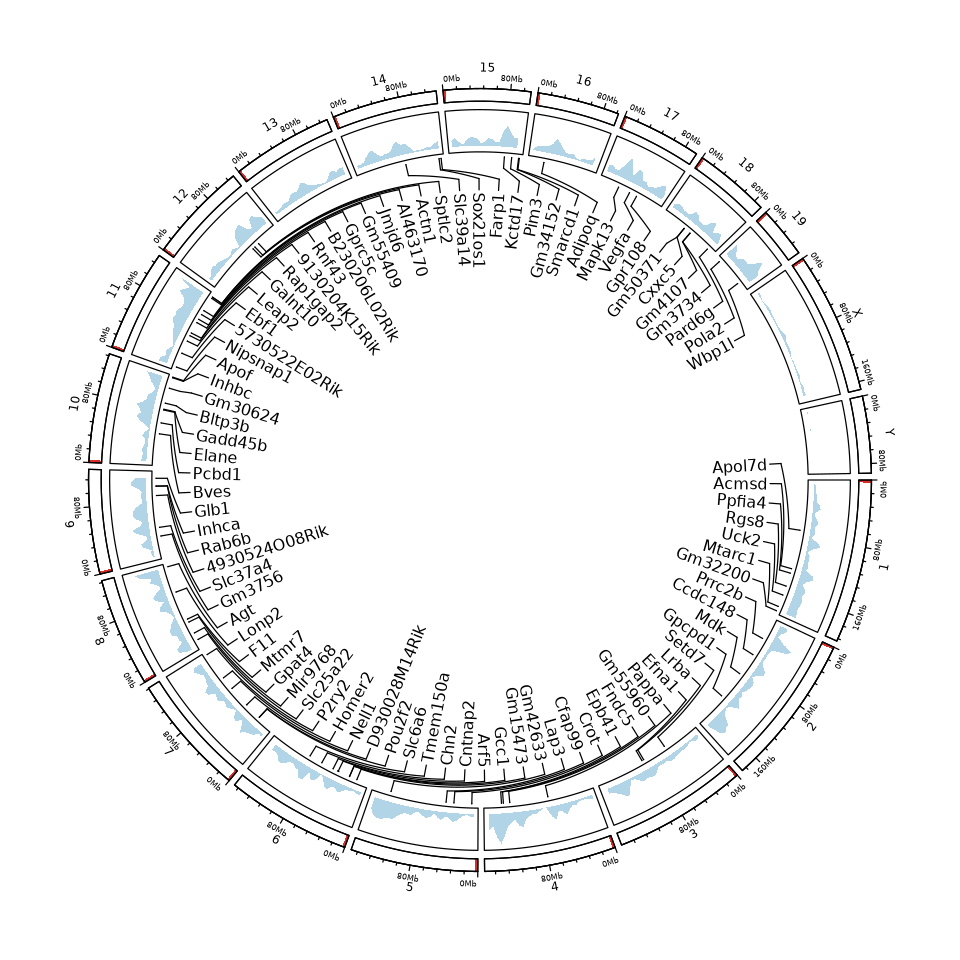

In [41]:
library(circlize)
# 参考教程：https://www.jianshu.com/p/3b73b029ee8e

par(bg = "white") # 设置背景为白色
options(repr.plot.width = 8, repr.plot.height = 8)  # 设置画布大小


# 设置输出文件名和尺寸（保存为图片文件时使用）
# png(paste0(report_dir, "circos_plot.png"), width = 2000, height = 2000, pointsize = 50)

circos.par(track.margin = c(0.00, 0.01)) # 调整上边距和下边距（单位是相对半径）

# 初始化坐标轴，并绘制染色体分布图（红线表示着丝粒）
# circos.initializeWithIdeogram(
#   cytoband = cytoband_path,
#   plotType = c("ideogram", "labels", "axis"),
#   chromosome.index = accession2chromosome,
#   # track.height = 0.2,
#   ideogram.height = 0.05
# )

# 初始化坐标轴
circos.initializeWithIdeogram(
  cytoband = cytoband_path,
  plotType = c("labels"),
  chromosome.index = accession2chromosome,
  labels.cex = 0.6 * par("cex"), # 染色体标签大小
)

# 第一圈：绘制染色体分布图（红线表示着丝粒）
circos.genomicIdeogram(
  cytoband = cytoband_path,
  track.height = 0.03,
  track.margin = c(0.01, 0.04) # 修改染色体图与染色体标签的距离
)

# 在染色体外层绘制坐标轴刻度标签
circos.track(
  track.index = get.current.track.index(),
  panel.fun = function(x, y) {
    circos.genomicAxis(
      h = "top",
      direction = "outside",
      labels.cex = 0.4 * par("cex"), # 坐标轴标签大小
    )
  },
  track.height = 0.03
)

# 第二圈：绘制DMR分布密度图（只需要"chr", "start", "end"列的数据）
circos.genomicDensity(
  DMRs,
  col = c("#67a9cf80"),
  track.height = 0.1
)
# 第三圈：绘制DMR基因名称
circos.genomicLabels(
  head(DMR_gene, 88), # 需要调整head数量控制标签刚好铺满一圈
  labels.column = 4,
  side = "inside",
  # col = "#ef8a62",
  # labels_height = 0.3, # 调整文字的高度
  connection_height = 0.08, # 调整连接线的长度
)
circos.clear()
# dev.off() # 关闭设备（保存为图片文件时使用）
